## Health Insurance Analysis in U.S. (2010 to 2016)

Health insurance coverage data compiled from the US Department of Health and Human Services and US Census Bureau.

*Source:* https://www.kaggle.com/hhs/health-insurance


In [2]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics

import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
# from sklearn.dummy import DummyClassifier
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
# from sklearn.grid_search import GridSearchCV

health_insurance = pd.read_csv("../metis_IDS_project/states.csv")


# Research Questions

**RQ1.** How has employer-sponsored health insurance coverage decreased the uninsured rates in various states?

**RQ2.** How has Medicare expansion decreased the uninsured rates in the states that expanded?

**RQ3.** Can we predict the next five years of nationwide health insurance coverage based on this data set?

# Cleaning Data


In [3]:
# Preview data
health_insurance.info()
health_insurance.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 14 columns):
State                                           52 non-null object
Uninsured Rate (2010)                           52 non-null object
Uninsured Rate (2015)                           52 non-null object
Uninsured Rate Change (2010-2015)               52 non-null object
Health Insurance Coverage Change (2010-2015)    52 non-null int64
Employer Health Insurance Coverage (2015)       52 non-null int64
Marketplace Health Insurance Coverage (2016)    52 non-null int64
Marketplace Tax Credits (2016)                  52 non-null int64
Average Monthly Tax Credit (2016)               52 non-null object
State Medicaid Expansion (2016)                 51 non-null object
Medicaid Enrollment (2013)                      50 non-null float64
Medicaid Enrollment (2016)                      52 non-null int64
Medicaid Enrollment Change (2013-2016)          50 non-null float64
Medicare Enrollment (2016)   

,State,Uninsured Rate (2010),Uninsured Rate (2015),Uninsured Rate Change (2010-2015),Health Insurance Coverage Change (2010-2015),Employer Health Insurance Coverage (2015),Marketplace Health Insurance Coverage (2016),Marketplace Tax Credits (2016),Average Monthly Tax Credit (2016),State Medicaid Expansion (2016),Medicaid Enrollment (2013),Medicaid Enrollment (2016),Medicaid Enrollment Change (2013-2016),Medicare Enrollment (2016)
0,Alabama,14.6%,10.1%,-4.5%,215000,2545000,165534,152206,$310,False,799176.0,910775,111599.0,989855
1,Alaska,19.9%,14.9%,-5%,36000,390000,17995,16205,$750,True,122334.0,166625,44291.0,88966
2,Arizona,16.9%,10.8%,-6.1%,410000,3288000,179445,124346,$230,True,1201770.0,1716198,514428.0,1175624
3,Arkansas,17.5%,9.5%,-8%,234000,1365000,63357,56843,$306,True,556851.0,920194,363343.0,606146
4,California,18.5%,8.6%,-9.9%,3826000,19552000,1415428,1239893,$309,True,7755381.0,11843081,4087700.0,5829777


In [4]:
# 1. Rename columns to remove spaces and condense names.

health_insurance.rename(columns={
    "Uninsured Rate (2010)":"Uninsured_Rate_2010",                            
    "Uninsured Rate (2015)":"Uninsured_Rate_2015",                            
    "Uninsured Rate Change (2010-2015)":"Uninsured_Rate_Change_2010_2015",
    "Health Insurance Coverage Change (2010-2015)":"Coverage_Change_2010_2015",     
    "Employer Health Insurance Coverage (2015)":"Employer_HI_Coverage_2015",        
    "Marketplace Health Insurance Coverage (2016)":"Marketplace_Coverage_2016",
    "Marketplace Tax Credits (2016)":"Marketplace_Tax_Credits_2016",
    "Average Monthly Tax Credit (2016)":"Avg_Monthly_Tax_Credit_2016",
    "State Medicaid Expansion (2016)":"State_MedicAID_Expansion_2016",
    "Medicaid Enrollment (2013)":"MedicAID_Enrollment_2013",
    "Medicaid Enrollment (2016)":"MedicAID_Enrollment_2016",
    "Medicaid Enrollment Change (2013-2016)":"MedicAID_Enrollment_Change_2013_2016",
    "Medicare Enrollment (2016)":"MediCARE_Enrollment_2016"       
    }, inplace=True)


In [5]:
# 2. Strip % and $. 
health_insurance["Uninsured_Rate_2010"] = health_insurance["Uninsured_Rate_2010"].apply(lambda x: x.replace('%',''))
health_insurance["Uninsured_Rate_2015"] = health_insurance["Uninsured_Rate_2015"].apply(lambda x: x.replace('%',''))
health_insurance["Uninsured_Rate_Change_2010_2015"] = health_insurance["Uninsured_Rate_Change_2010_2015"].apply(lambda x: x.replace('%',''))
health_insurance["Avg_Monthly_Tax_Credit_2016"] = health_insurance["Avg_Monthly_Tax_Credit_2016"].apply(lambda x: x.replace('$',''))

# health_insurance.head()


In [6]:
# 3. Convert objects to floats.
health_insurance["Uninsured_Rate_2010"] = health_insurance["Uninsured_Rate_2010"].astype(str).astype(float)
health_insurance["Uninsured_Rate_2015"] = health_insurance["Uninsured_Rate_2015"].astype(str).astype(float)
health_insurance["Uninsured_Rate_Change_2010_2015"] = health_insurance["Uninsured_Rate_Change_2010_2015"].astype(str).astype(float)
health_insurance["Avg_Monthly_Tax_Credit_2016"] = health_insurance["Avg_Monthly_Tax_Credit_2016"].astype(str).astype(float)

# health_insurance.dtypes


In [7]:
# 4. Replace bools (True/False) with Yes/No (column: State_MedicAID_Expansion_2016).
health_insurance = health_insurance.replace(to_replace = [False, True], value = ["No", "Yes"])


In [8]:
# 5. Replace missing data points (NaN) with zero. 
health_insurance.replace(to_replace = np.nan, value =0)
health_insurance.isnull().sum()


State                                   0
Uninsured_Rate_2010                     0
Uninsured_Rate_2015                     0
Uninsured_Rate_Change_2010_2015         0
Coverage_Change_2010_2015               0
Employer_HI_Coverage_2015               0
Marketplace_Coverage_2016               0
Marketplace_Tax_Credits_2016            0
Avg_Monthly_Tax_Credit_2016             0
State_MedicAID_Expansion_2016           1
MedicAID_Enrollment_2013                2
MedicAID_Enrollment_2016                0
MedicAID_Enrollment_Change_2013_2016    2
MediCARE_Enrollment_2016                0
dtype: int64

In [9]:
# Clean data set 
health_insurance.head()


,State,Uninsured_Rate_2010,Uninsured_Rate_2015,Uninsured_Rate_Change_2010_2015,Coverage_Change_2010_2015,Employer_HI_Coverage_2015,Marketplace_Coverage_2016,Marketplace_Tax_Credits_2016,Avg_Monthly_Tax_Credit_2016,State_MedicAID_Expansion_2016,MedicAID_Enrollment_2013,MedicAID_Enrollment_2016,MedicAID_Enrollment_Change_2013_2016,MediCARE_Enrollment_2016
0,Alabama,14.6,10.1,-4.5,215000,2545000,165534,152206,310.0,No,799176.0,910775,111599.0,989855
1,Alaska,19.9,14.9,-5.0,36000,390000,17995,16205,750.0,Yes,122334.0,166625,44291.0,88966
2,Arizona,16.9,10.8,-6.1,410000,3288000,179445,124346,230.0,Yes,1201770.0,1716198,514428.0,1175624
3,Arkansas,17.5,9.5,-8.0,234000,1365000,63357,56843,306.0,Yes,556851.0,920194,363343.0,606146
4,California,18.5,8.6,-9.9,3826000,19552000,1415428,1239893,309.0,Yes,7755381.0,11843081,4087700.0,5829777


# Correlation 

In [10]:
health_insurance.corr()


,Uninsured_Rate_2010,Uninsured_Rate_2015,Uninsured_Rate_Change_2010_2015,Coverage_Change_2010_2015,Employer_HI_Coverage_2015,Marketplace_Coverage_2016,Marketplace_Tax_Credits_2016,Avg_Monthly_Tax_Credit_2016,MedicAID_Enrollment_2013,MedicAID_Enrollment_2016,MedicAID_Enrollment_Change_2013_2016,MediCARE_Enrollment_2016
Uninsured_Rate_2010,1.000000,0.869074,-0.512217,0.127835,0.081566,0.127179,0.133772,0.259979,0.078675,0.088080,0.086789,0.084742
Uninsured_Rate_2015,0.869074,1.000000,-0.160628,0.072594,0.050499,0.098219,0.104914,0.387787,0.047176,0.044161,0.017247,0.053159
Uninsured_Rate_Change_2010_2015,-0.512217,-0.160628,1.000000,0.507685,0.562773,0.542041,0.538093,0.050172,0.576815,0.541092,0.517548,0.561724
Coverage_Change_2010_2015,0.127835,0.072594,0.507685,1.000000,0.994852,0.994007,0.992927,-0.020190,0.995612,0.997142,0.993211,0.994144
Employer_HI_Coverage_2015,0.081566,0.050499,0.562773,0.994852,1.000000,0.993882,0.991851,-0.029105,0.998722,0.998084,0.985844,0.999484
Marketplace_Coverage_2016,0.127179,0.098219,0.542041,0.994007,0.993882,1.000000,0.999825,-0.008075,0.991694,0.991108,0.979194,0.995248
Marketplace_Tax_Credits_2016,0.133772,0.104914,0.538093,0.992927,0.991851,0.999825,1.000000,-0.003210,0.989580,0.989097,0.977569,0.993561
Avg_Monthly_Tax_Credit_2016,0.259979,0.387787,0.050172,-0.020190,-0.029105,-0.008075,-0.003210,1.000000,-0.027559,-0.030081,-0.013936,-0.025097
MedicAID_Enrollment_2013,0.078675,0.047176,0.576815,0.995612,0.998722,0.991694,0.989580,-0.027559,1.000000,0.999405,0.987719,0.998103
MedicAID_Enrollment_2016,0.088080,0.044161,0.541092,0.997142,0.998084,0.991108,0.989097,-0.030081,0.999405,1.000000,0.992505,0.997334


In [11]:
# plt.figure(figsize=(10,10))
# hi_corr = health_insurance.corr()
# heatmap = sns.heatmap(hi_corr, annot=True, linewidth=0.1, cmap='coolwarm', ) 
# bottom, top = heatmap.get_ylim()
# heatmap.set_ylim(bottom + 0.5, top - 0.5)
# plt.title("Correlation of uninsured rates and insurance coverage types")
# plt.show(heatmap)


# GroupBy

In [12]:
# Group by states that expanded Medicaid in 2016
# Expanded_Group = 32 entries
# Nonexp_Group = 19 = entries
State_MedicAID_Expansion_2016_Group = health_insurance.groupby('State_MedicAID_Expansion_2016')
Expanded_Group = State_MedicAID_Expansion_2016_Group.get_group('Yes')
Nonexp_Group = State_MedicAID_Expansion_2016_Group.get_group('No') 
# Expanded_Group.info()
# Nonexp_Group.info()

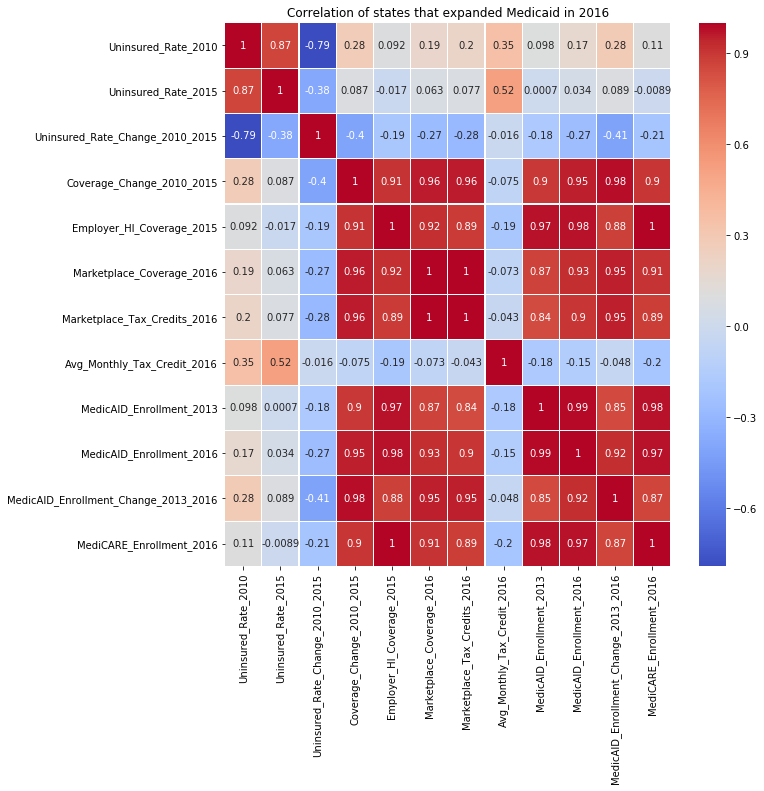

In [13]:
# Expanded_Group = Group of states that expanded Medicaid in 2016

plt.figure(figsize=(10,10))
Expanded_Group_corr = Expanded_Group.corr()
heatmap = sns.heatmap(Expanded_Group_corr, annot=True, linewidth=0.1, cmap='coolwarm', ) 
bottom, top = heatmap.get_ylim()
heatmap.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Correlation of states that expanded Medicaid in 2016")
plt.show(heatmap)


In [14]:
# Nonexp_Group [Not working, NaN]

# TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

# plt.figure(figsize=(10,10))
# Nonexp_Group_corr = Nonexp_Group.corr()
# heatmap = sns.heatmap(Nonexp_Group, annot=True, linewidth=0.1, cmap='coolwarm', ) 
# bottom, top = heatmap.get_ylim()
# heatmap.set_ylim(bottom + 0.5, top - 0.5)
# plt.title("Correlation of states that did not expand Medicaid  in 2016")
# plt.show(heatmap)

# Nonexp_Group.isnull().sum()

In [15]:
# Removing object columns: State & State_MedicAID_Expansion_2016
Expanded_Group_nums = Expanded_Group.drop(['State','State_MedicAID_Expansion_2016'], axis=1)
# Expanded_Group_nums.head(2)


/Users/sandraparedes/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/sandraparedes/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


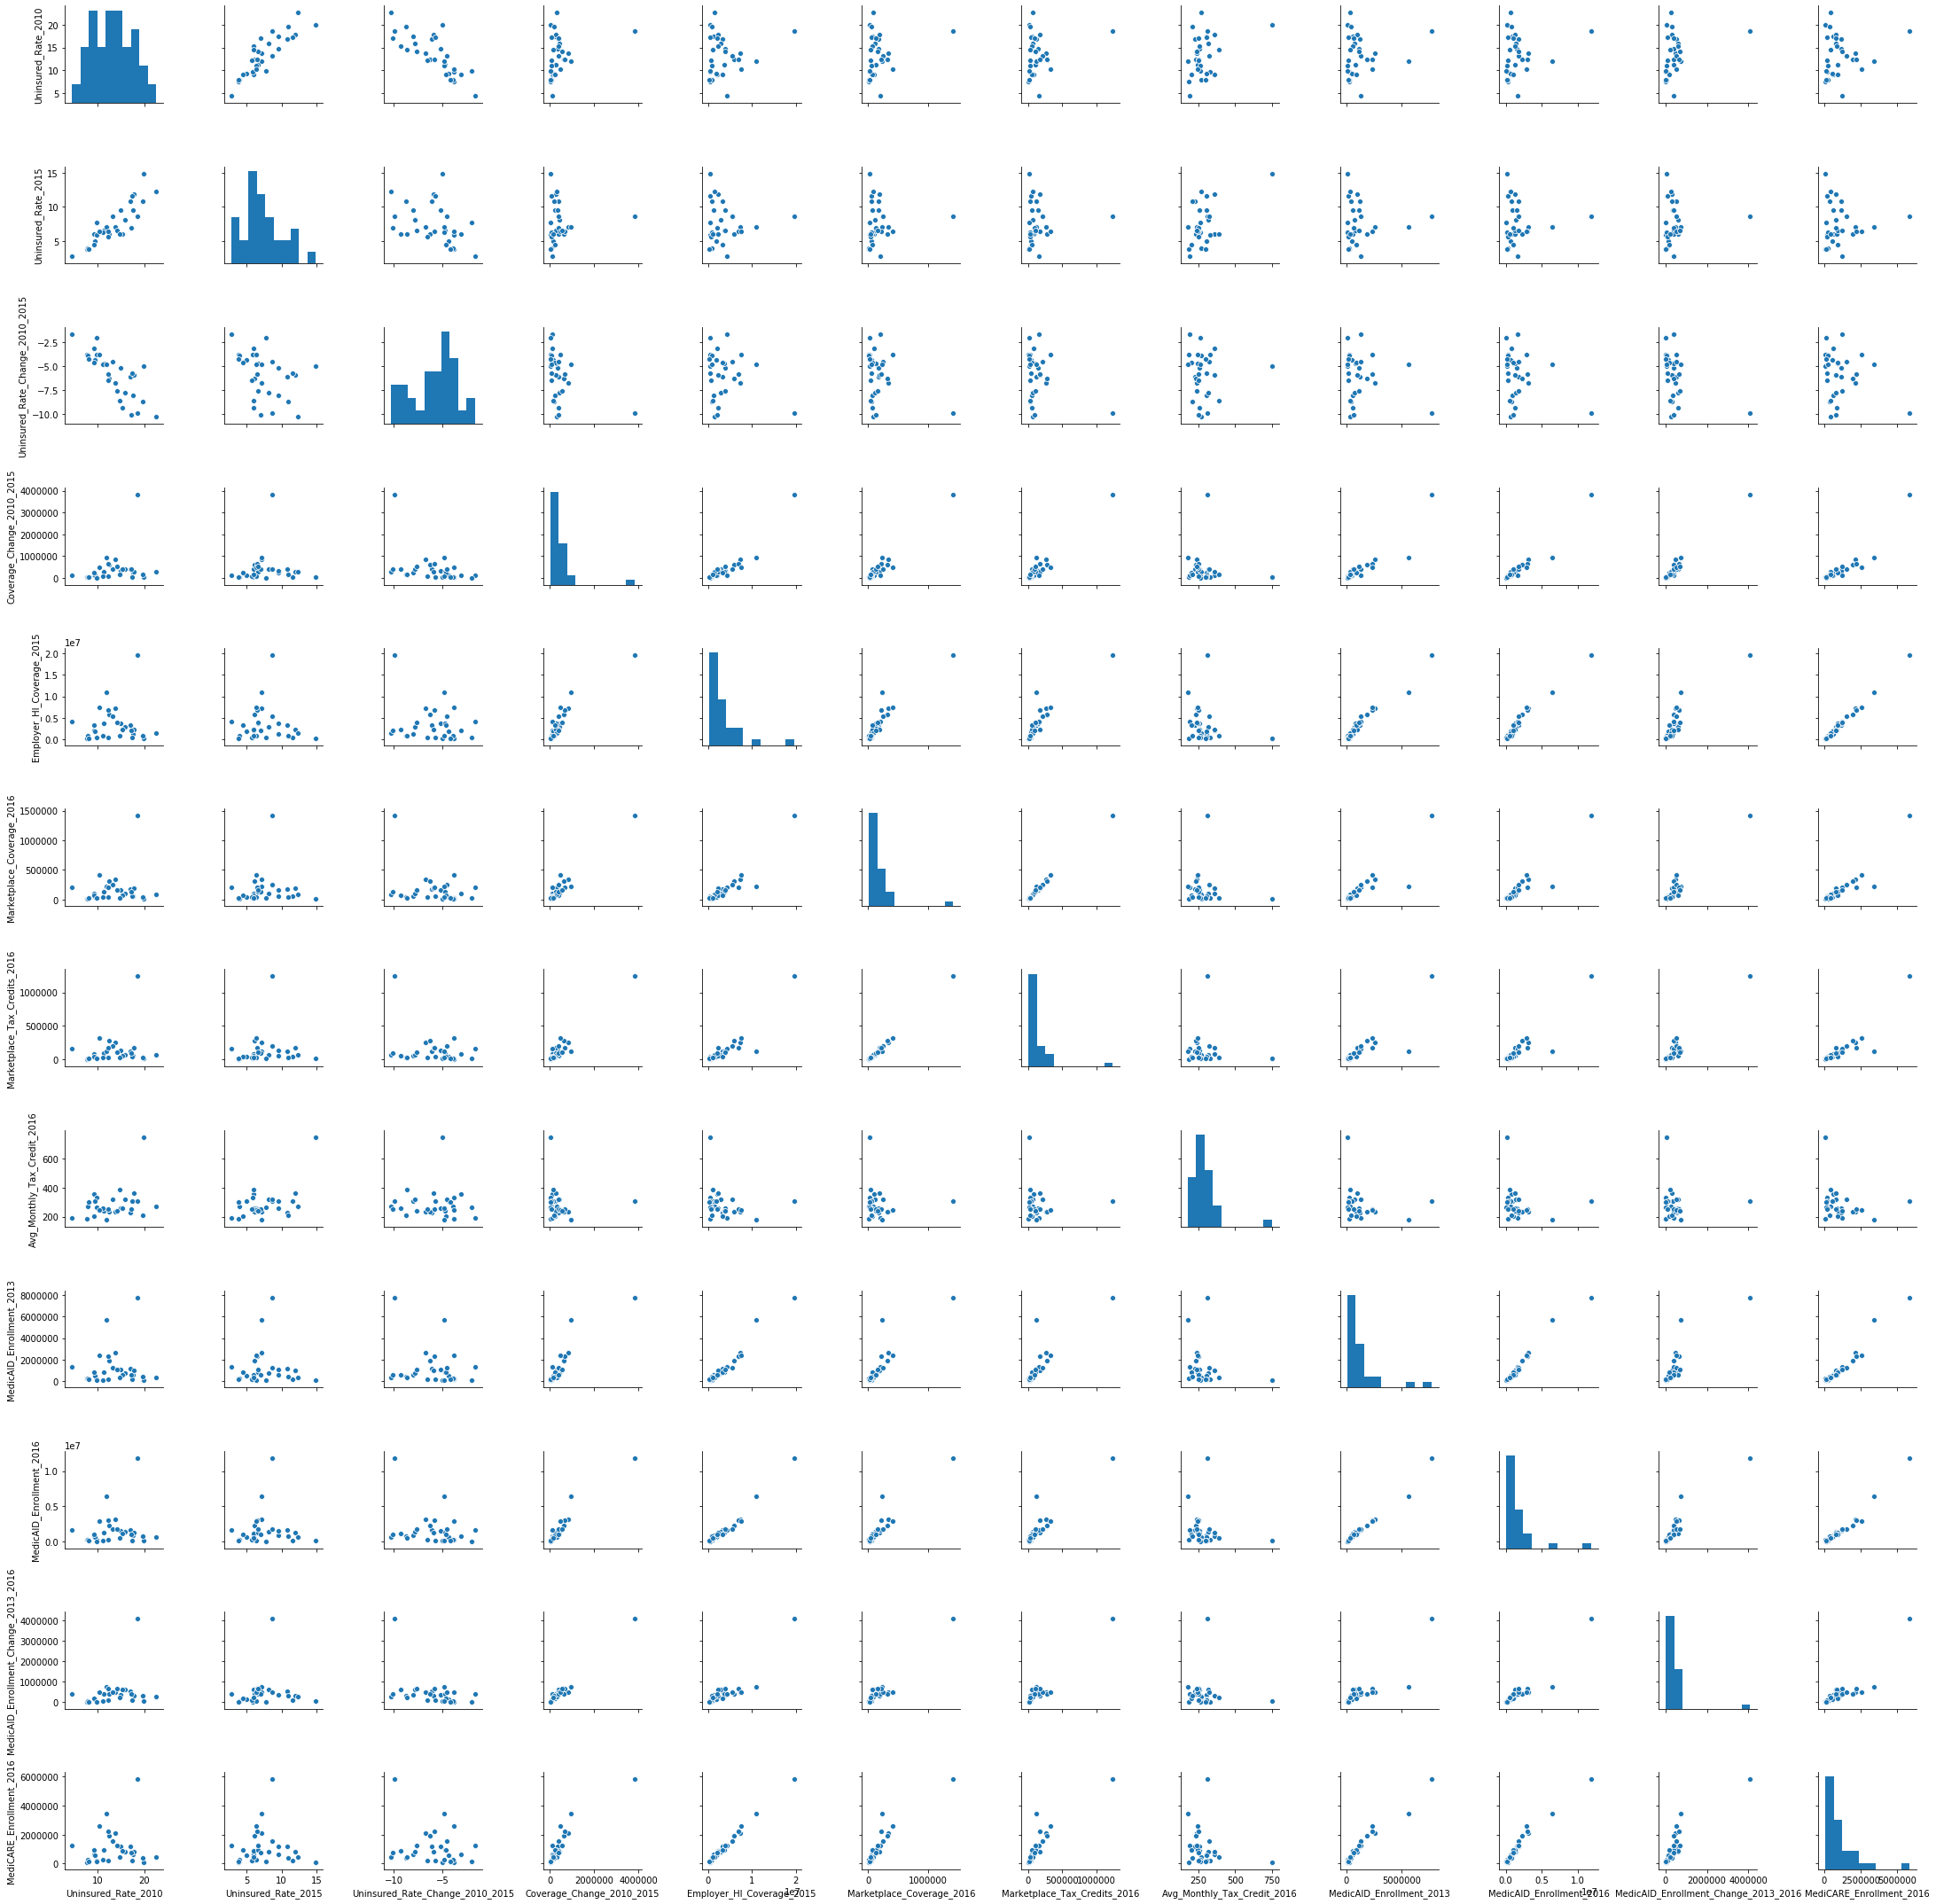

In [16]:
# sns.pairplot(health_insurance, x_vars=['Employer_HI_Coverage_2015','Marketplace_Coverage_2016'], y_vars='Uninsured_Rate_2015', height=6, aspect=0.8);
sns.pairplot(Expanded_Group_nums)
# sns.pairplot(health_insurance)


# Linear Regression

In [26]:
# State                                   
# Uninsured_Rate_2010                     
# Uninsured_Rate_2015                     
# Uninsured_Rate_Change_2010_2015         
# Coverage_Change_2010_2015               
# Employer_HI_Coverage_2015               
# Marketplace_Coverage_2016               
# Marketplace_Tax_Credits_2016            
# Avg_Monthly_Tax_Credit_2016             
# State_MedicAID_Expansion_2016           
# MedicAID_Enrollment_2013                
# MedicAID_Enrollment_2016                
# MedicAID_Enrollment_Change_2013_2016    
# MediCARE_Enrollment_2016                

Expanded_Group_nums.round()

# X and y
feature_cols = ['Marketplace_Coverage_2016']
X = Expanded_Group_nums[feature_cols]
y = Expanded_Group_nums.Employer_HI_Coverage_2015

cvg_linreg = LinearRegression()
cvg_linreg.fit(X, y)

print("The y intercept:", cvg_linreg.intercept_.round(0))
print("The single coefficient:", cvg_linreg.coef_.round(0))

The y intercept: 1070693.0
The single coefficient: [14.]


(0, 41247176.10998475)

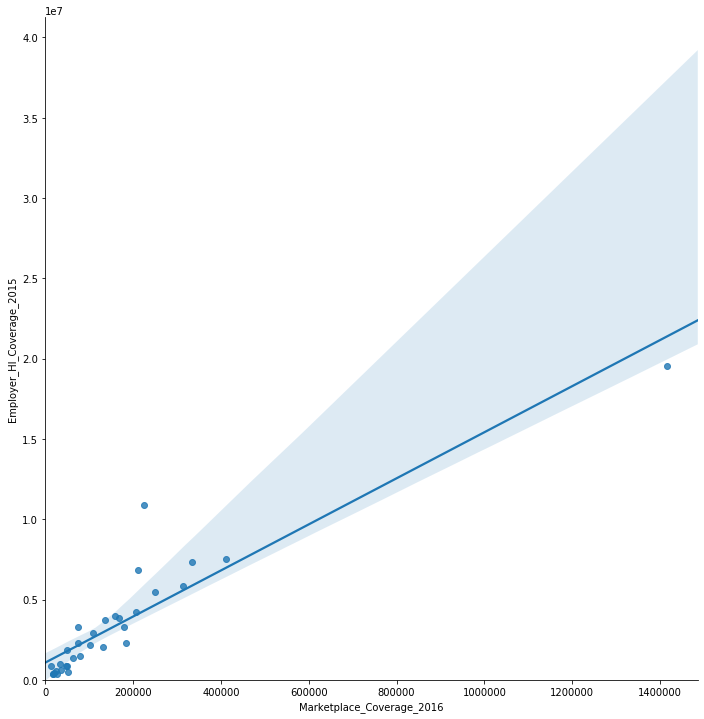

In [28]:
sns.pairplot(Expanded_Group_nums,x_vars=['Marketplace_Coverage_2016'],y_vars='Employer_HI_Coverage_2015',height=10, aspect=1,kind='reg')
sns.mpl.pyplot.xlim(0,)
sns.mpl.pyplot.ylim(0,)

In [31]:
cvg_linreg.predict([[3000]]).round(0)

array([1113747.])